# CrossBee workflow demo based on Python Script Modules for LBD Text Mining Analysis

CrossBee is a system that recommends bridging terms (*b-terms*) through an ensemble-based ranking method. It aids experts in uncovering hidden connections between unrelated domains. The user-friendly CrossBee web application facilitates the ranking, exploration, and efficient investigation of these cross-domain links.

Import LBD components from notebooks.

In [3]:
import logging

# Initialize logging with a basic configuration
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s: %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

In [4]:
import import_ipynb
import LBD_01_data_acquisition
import LBD_02_data_preprocessing
import LBD_03_feature_extraction
import LBD_04_text_mining
import LBD_05_results_analysis
import LBD_06_visualization

importing Jupyter notebook from LBD_01_data_acquisition.ipynb
importing Jupyter notebook from LBD_02_data_preprocessing.ipynb


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bojan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bojan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


importing Jupyter notebook from LBD_03_feature_extraction.ipynb
importing Jupyter notebook from LBD_04_text_mining.ipynb
importing Jupyter notebook from LBD_05_results_analysis.ipynb
importing Jupyter notebook from LBD_06_visualization.ipynb


In [5]:
import nltk
import numpy as np
import itertools
import pandas as pd
# import pickle
# import json
import spacy
from typing import List, Dict

Define domain name and load text from file.

In [6]:
domainName = 'Migraine-Magnesium'
fileName = 'input/Magnesium_Migraine_before1988.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
lines[:7]

2024-06-21 13:02:39: INFO - Loaded 16156 lines from "input/Magnesium_Migraine_before1988.txt".


['1Mag: !Mag Characterization of Clostridium thermocellum JW20.\n',
 '2Mag: !Mag Organochlorine and heavy metal contamination in the eggs of the Spanish Imperial Eagle (Aquila (heliaca) adalberti) and accompanying changes in eggshell morphology and chemistry.\n',
 '3Mag: !Mag A molecular orbital study of a model of the Mg2+ coordination complex of the self splicing reaction of ribosomal RNA.\n',
 '4Mag: !Mag Distribution and diagenesis of microfossils from the lower Proterozoic Duck Creek Dolomite, Western Australia.\n',
 '5Mag: !Mag Microfossils from oolites and pisolites of the Upper Proterozoic Eleonore Bay Group, Central East Greenland.\n',
 '6Mag: !Mag Carbonates and sulfates in CI chondrites:  formation by aqueous activity on the parent body.\n',
 '7Mag: !Mag The influence of prebiotic-type organic molecules on the crystallization of Al and Mg hydroxides.\n']

Preprocess documents into a dictionary and extract documents as strings in a list.

In [7]:
docs_dict = LBD_02_data_preprocessing.construct_dict_from_list(lines)

keep_list = ["p"]
remove_list = ["migraine", "magnesium"]
prep_docs_dict = LBD_02_data_preprocessing.preprocess_docs_dict(
    docs_dict, keep_list = keep_list, remove_list = remove_list, mesh_word_list = [], \
    cleaning = True, remove_stopwords = True, lemmatization = True, \
    min_word_length = 0, keep_only_nouns = False, keep_only_mesh = False, stemming = False, stem_type = None)

ids_list = LBD_02_data_preprocessing.extract_ids_list(prep_docs_dict)
prep_docs_list = LBD_02_data_preprocessing.extract_preprocessed_documents_list(prep_docs_dict)


2024-06-21 13:02:40: INFO - Text cleaning ...
2024-06-21 13:02:44: INFO - Removing stopwords ...
2024-06-21 13:02:44: INFO - Lematization ...
2024-06-21 13:02:45: INFO - Preprocessing finished.


Display the first dictionary items, document (pubmed) ids and preprocessed documents.

In [8]:
dict(itertools.islice(prep_docs_dict.items(), 7))

{'1Mag': {'domain': 'Mag',
  'document': 'Characterization of Clostridium thermocellum JW20.',
  'preprocessed': 'characterization clostridium thermocellum jw20'},
 '2Mag': {'domain': 'Mag',
  'document': 'Organochlorine and heavy metal contamination in the eggs of the Spanish Imperial Eagle (Aquila (heliaca) adalberti) and accompanying changes in eggshell morphology and chemistry.',
  'preprocessed': 'organochlorine heavy metal contamination egg spanish imperial eagle aquila heliaca adalberti accompany change eggshell morphology chemistry'},
 '3Mag': {'domain': 'Mag',
  'document': 'A molecular orbital study of a model of the Mg2+ coordination complex of the self splicing reaction of ribosomal RNA.',
  'preprocessed': 'molecular orbital study model mg2 coordination complex self splice reaction ribosomal rna'},
 '4Mag': {'domain': 'Mag',
  'document': 'Distribution and diagenesis of microfossils from the lower Proterozoic Duck Creek Dolomite, Western Australia.',
  'preprocessed': 'dis

In [9]:
prep_docs_list[:7]

['characterization clostridium thermocellum jw20',
 'organochlorine heavy metal contamination egg spanish imperial eagle aquila heliaca adalberti accompany change eggshell morphology chemistry',
 'molecular orbital study model mg2 coordination complex self splice reaction ribosomal rna',
 'distribution diagenesis microfossils lower proterozoic duck creek dolomite western australia',
 'microfossils oolites pisolites upper proterozoic eleonore bay group central east greenland',
 'carbonate sulfate ci chondrites formation aqueous activity parent body',
 'influence prebiotictype organic molecules crystallization al mg hydroxides']

Generate bag-of-words matrix from the list of preprocessed documents. Remove ngram words that occur less than *min_ngram_count* times (3 in our case) in the whole corpus of documents.

In [10]:
ngram_size = 3
min_df = 1

# BOW representation
word_list, bow_matrix = LBD_03_feature_extraction.create_bag_of_words(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all n-grams: ', len(word_list))
# print(word_list)
# print(bow_matrix)

# remove nterms with frequency count less than min_count_ngram from vocabulary word_list and bow_matrix
min_count_ngram = 2
tmp_sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

tmp_sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

tmp_filter_columns = []
for i, word in enumerate(word_list):
    if not LBD_03_feature_extraction.word_is_nterm(word):
        # if word in mesh_word_list:
        tmp_filter_columns.append(i)
    else:
        if tmp_sum_count_word_in_docs[word] >= min_count_ngram:
            tmp_filter_columns.append(i)

tmp_filter_rows = []
for i, id in enumerate(ids_list):
    tmp_filter_rows.append(i)

tmp_filtered_word_list, tmp_filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, bow_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
bow_matrix = tmp_filtered_bow_matrix
print('Number of terms in preprocessed vocabulary after removing infrequent n-grams: ', len(word_list))

LBD_02_data_preprocessing.save_list_to_file(word_list, "output/_list.txt")
LBD_02_data_preprocessing.save_list_to_file(prep_docs_list, "output/_prep_list.txt")


Number of terms in initial vocabulary with all n-grams:  162022
Number of terms in preprocessed vocabulary after removing infrequent n-grams:  29841


Compute margins for bag-of-word matrix. Prepare also the dictionaries of words and documents sorted according to the sum of word count in BOW matrix (*bow_matrix*)

In [11]:
sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

sum_count_words_in_doc = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, bow_matrix)

print('Number of documents in which each word is present: ', dict(itertools.islice(sum_count_docs_containing_word.items(), 7)))
print('Number of occurences of each word in all documents: ', dict(itertools.islice(sum_count_word_in_docs.items(), 7)))
print('Number of words in each document: ', dict(itertools.islice(sum_count_words_in_doc.items(), 7)))

# Compute the order of rows (documents) and columns (words) in the bow matrix so that the most frequent words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_word_in_docs, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_words_in_doc, reverse=True), ids_list) 

# Rearange (filter) the bow matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, bow_matrix, filter_rows, filter_columns)
print('The first few documents in the rows of the filtered bow matrix: ', filtered_ids_list[:7])
print('The first few words in the columns of the filtered bow matrix: ', filtered_word_list[:7])

Number of documents in which each word is present:  {'000dalton': 1, '1030nm': 1, '10formyltetrahydrofolate': 1, '10year': 1, '10yearold': 1, '110kd': 2, '110orthophenanthroline': 1}
Number of occurences of each word in all documents:  {'000dalton': 1, '1030nm': 1, '10formyltetrahydrofolate': 1, '10year': 1, '10yearold': 1, '110kd': 2, '110orthophenanthroline': 1}
Number of words in each document:  {'1Mag': 4, '2Mag': 17, '3Mag': 15, '4Mag': 11, '5Mag': 15, '6Mag': 9, '7Mag': 9}
The first few documents in the rows of the filtered bow matrix:  ['9710Mag', '9711Mag', '1632Mag', '6221Mag', '7063Mag', '7064Mag', '586Mag']
The first few words in the columns of the filtered bow matrix:  ['effect', 'calcium', 'study', 'rat', 'headache', 'treatment', 'patients']


Visualize bag-of-words matrix.

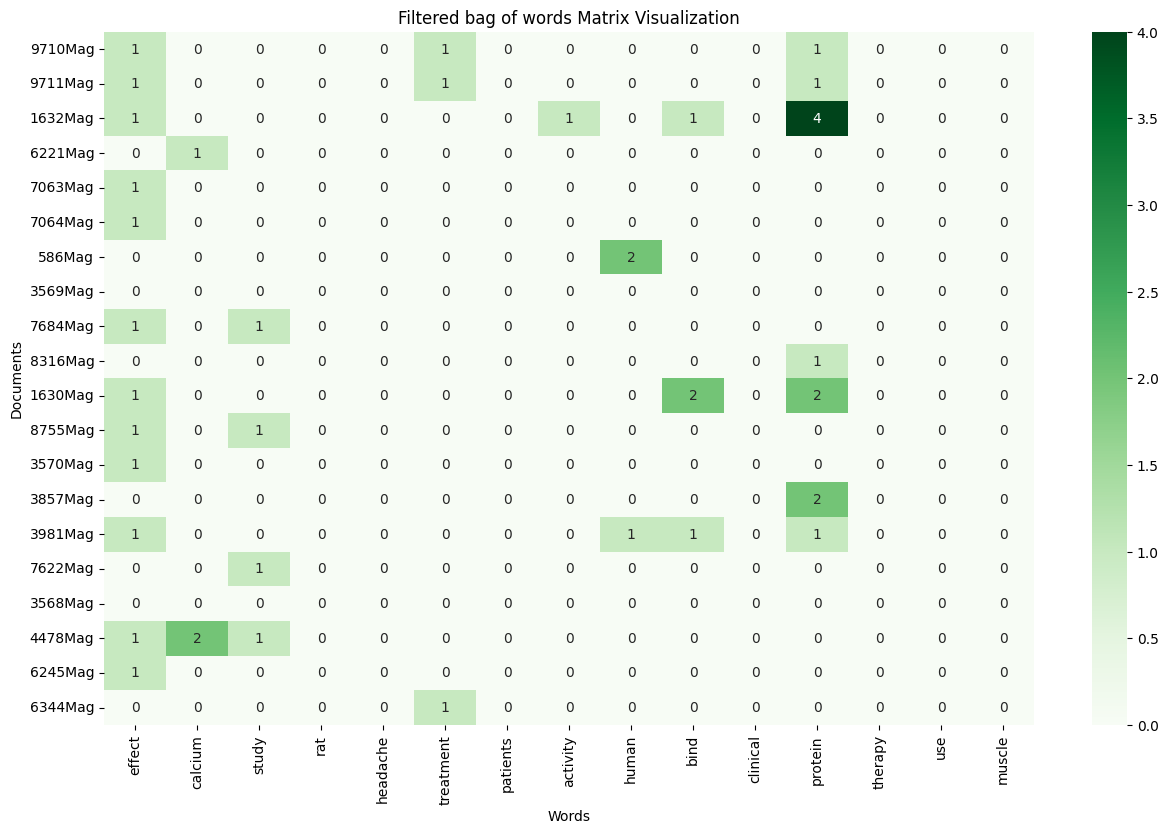

In [12]:
first_row = 0
last_row = 20
first_column = 0
last_column = 15
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered bag of words', \
                                           filtered_bow_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], \
                                           filtered_word_list[first_column:last_column], as_int = True)

Generate tf-idf matrix from the list of preprocessed documents.

In [13]:
# TF-IDF representation
word_list, tfidf_matrix = LBD_03_feature_extraction.create_tfidf(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all ngrams: ', len(word_list))
# print(word_list)
# print(tfidf_matrix)

# Rearange (filter) the tfidf matrix according to the previously computed order from bow matrix.
tmp_filtered_word_list, tmp_filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, tfidf_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
tfidf_matrix = tmp_filtered_tfidf_matrix
print('Number of terms in preprocessed vocabulary after removing infrequent ngrams: ', len(word_list))

Number of terms in initial vocabulary with all ngrams:  162022
Number of terms in preprocessed vocabulary after removing infrequent ngrams:  29841


Compute margins for tf-idf matrix.

In [14]:
sum_word_tfidf = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, tfidf_matrix)
max_word_tfidf = LBD_03_feature_extraction.max_tfidf_each_word_in_all_documents(word_list, tfidf_matrix)

sum_doc_tfidf = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, tfidf_matrix)
max_doc_tfidf = LBD_03_feature_extraction.max_tfidf_all_words_in_each_document(ids_list, tfidf_matrix)

print('Sum of tfidf for each word: ', dict(itertools.islice(sum_word_tfidf.items(), 7)))
print('Max of tfidf for each word: ', dict(itertools.islice(max_word_tfidf.items(), 7)))

print('Sum of tfidf for each document: ', dict(itertools.islice(sum_doc_tfidf.items(), 7)))
print('Max of tfidf for each document: ', dict(itertools.islice(max_doc_tfidf.items(), 7)))

# Compute the order of rows (documents) and columns (words) in the tfidf matrix so that the most important words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_doc_tfidf, reverse=True), ids_list) 

# Rearange (filter) the bow matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, tfidf_matrix, filter_rows, filter_columns)

Sum of tfidf for each word:  {'000dalton': 0.2350964265937192, '1030nm': 0.24033819927373012, '10formyltetrahydrofolate': 0.2314552656088666, '10year': 0.1748468666218845, '10yearold': 0.26084551955375596, '110kd': 0.49501968534162366, '110orthophenanthroline': 0.24490369136704976}
Max of tfidf for each word:  {'000dalton': 0.2350964265937192, '1030nm': 0.24033819927373012, '10formyltetrahydrofolate': 0.2314552656088666, '10year': 0.1748468666218845, '10yearold': 0.26084551955375596, '110kd': 0.25439460319775525, '110orthophenanthroline': 0.24490369136704976}
Sum of tfidf for each document:  {'1Mag': 1.1709143219138545, '2Mag': 2.263475974053593, '3Mag': 2.139393389015491, '4Mag': 1.9537838243107828, '5Mag': 2.5797535496317705, '6Mag': 1.500339745108976, '7Mag': 1.717156158528271}
Max of tfidf for each document:  {'1Mag': 0.35634548636395214, '2Mag': 0.15684961038296918, '3Mag': 0.18619892336778945, '4Mag': 0.20131608263916112, '5Mag': 0.1914682398777895, '6Mag': 0.22136991336064005, '

Visualize tf-idf matrix.

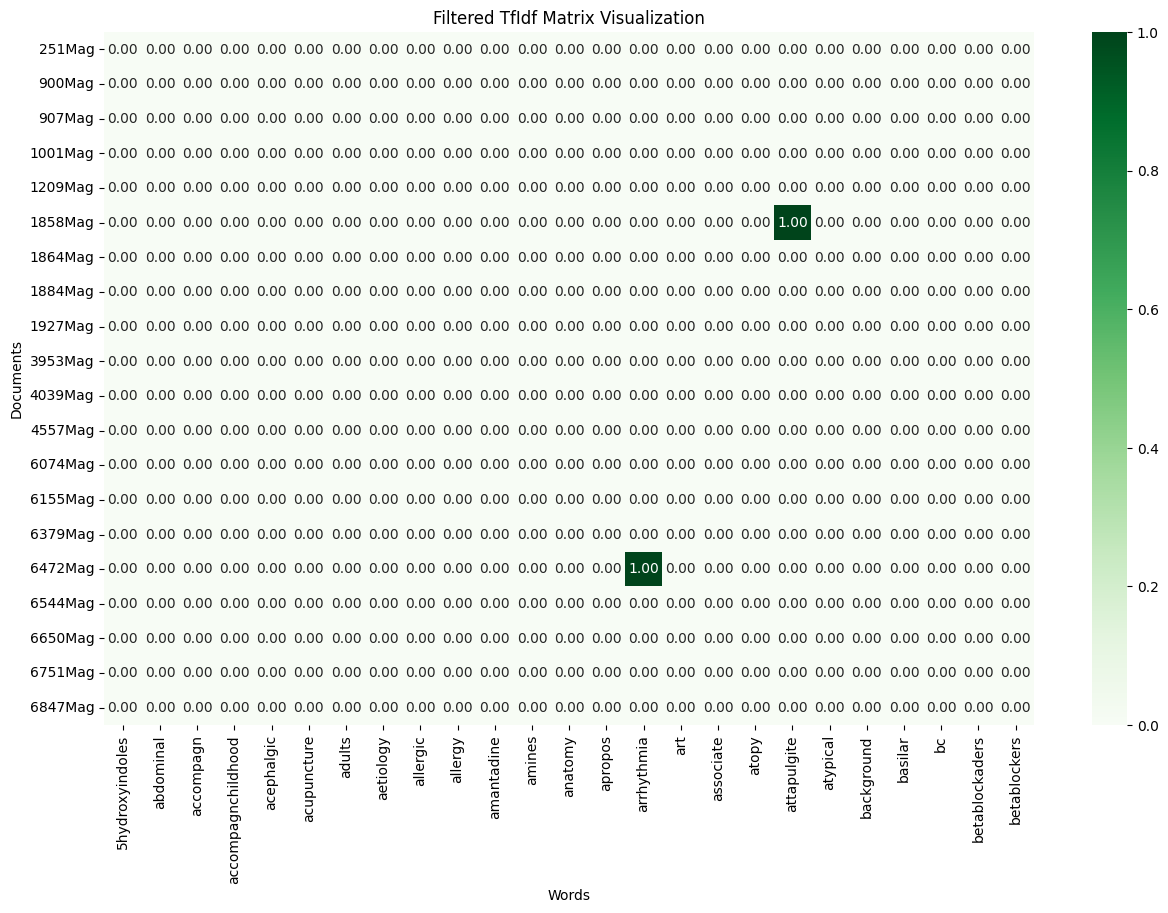

In [15]:
first_row = 0
last_row = 20
first_column = 0
last_column = 25
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered TfIdf', filtered_tfidf_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], filtered_word_list[first_column:last_column], as_int = False)

Generate a list of the domain names of all the documents and a list of unique domain names.

In [16]:
domains_list = LBD_02_data_preprocessing.extract_domain_names_list(prep_docs_dict)
print('Domain names for the first few documents: ', domains_list[:7])
unique_domains_list = LBD_02_data_preprocessing.extract_unique_domain_names_list(prep_docs_dict)
print('A list of all uniques domain names in all the documents: ', unique_domains_list)

Domain names for the first few documents:  ['Mag', 'Mag', 'Mag', 'Mag', 'Mag', 'Mag', 'Mag']
A list of all uniques domain names in all the documents:  ['Mag', 'Mig']


In [17]:
# Generate domains_bow_matrix from bow_matrix using domain_names list to add bow_matrix rows for each unique domain name into a single row
domains_bow_matrix = np.empty((0, bow_matrix.shape[1]))
no_documents_in_domain = {}
for i, domain_name in enumerate(unique_domains_list):
    domain_docs_indices = [i for i, label in enumerate(domains_list) if label == domain_name]
    no_documents_in_domain[domain_name] = len(domain_docs_indices)
    print(domain_docs_indices[:7])
    tmp = (bow_matrix[domain_docs_indices,:]).sum(axis=0)
    print(i, tmp)
    domains_bow_matrix = np.vstack((domains_bow_matrix, tmp))
    # Compute centroid for the current cluster
    #centroid_x = np.mean(pca_result[cluster_docs_indices, 0])
    #centroid_y = np.mean(pca_result[cluster_docs_indices, 1])
print(domains_bow_matrix)
print(no_documents_in_domain)

[0, 1, 2, 3, 4, 5, 6]
0 [1 1 1 ... 3 3 1]
[10000, 10001, 10002, 10003, 10004, 10005, 10006]
1 [0 0 0 ... 0 0 0]
[[1. 1. 1. ... 3. 3. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
{'Mag': 10000, 'Mig': 6156}


In [18]:
def cell_value_in_bow_matrix(bow_matrix, domain_name, word):
    """
    """
    line_idx = unique_domains_list.index(domain_name)
    column_idx = word_list.index(word)
    return(bow_matrix[line_idx, column_idx])

cell_value_in_bow_matrix(domains_bow_matrix, unique_domains_list[0], word_list[0])


1.0

In [19]:
print("Dictionary of words, count and max(tfidf):")

max_word_tfidf_selected = {}
sum_word_tfidf_selected = {}
for word in max_word_tfidf.keys():
    if sum_count_docs_containing_word[word] >= 1:
        passed = True
        for domain_name in unique_domains_list:
            if cell_value_in_bow_matrix(domains_bow_matrix, domain_name, word) <= 0:
                passed = False
        if passed:
            max_word_tfidf_selected[word] = max_word_tfidf[word]
            sum_word_tfidf_selected[word] = sum_word_tfidf[word]
         
import itertools
print('All the words in vocabulary: ', len(max_word_tfidf))
print('Selected bterm candidate words: ', len(max_word_tfidf_selected), ' ', dict(itertools.islice(max_word_tfidf_selected.items(), 30)))

max_word_tfidf_selected_sorted = LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf_selected, True)
sum_word_tfidf_selected_sorted = LBD_02_data_preprocessing.sort_dict_by_value(sum_word_tfidf_selected, True)

print()

print('MAX Sorted bterm candidate words: ', len(max_word_tfidf_selected_sorted), ' ', dict(itertools.islice(max_word_tfidf_selected_sorted.items(), 30)))
print('First and last sorted bterm word: ', list(max_word_tfidf_selected_sorted.items())[0], ' ', list(max_word_tfidf_selected_sorted.items())[-1])
print('Mean value of max tfidf values: ', np.array(list(max_word_tfidf_selected_sorted.values())).mean())

print()

print('SUM Sorted bterm candidate words: ', len(sum_word_tfidf_selected_sorted), ' ', dict(itertools.islice(sum_word_tfidf_selected_sorted.items(), 30)))
print('First and last sorted bterm word: ', list(sum_word_tfidf_selected_sorted.items())[0], ' ', list(sum_word_tfidf_selected_sorted.items())[-1])
print('Mean value of sum tfidf values: ', np.array(list(sum_word_tfidf_selected_sorted.values())).mean())

Dictionary of words, count and max(tfidf):
All the words in vocabulary:  29841
Selected bterm candidate words:  3576   {'12th': 0.2210993906892484, '1alpha': 0.16441720006176808, '1st': 0.2674114254326264, '26th': 0.253946950033883, '5ht': 0.3695097121163408, '5hydroxyindole': 0.27807835581609497, '5hydroxytryptamine': 0.3569432481753387, '5hydroxytryptamine release': 0.29314692064613096, '5year': 0.312065423969096, 'ab': 0.2264729387343013, 'abc': 0.3540097536207147, 'abdominal': 1.0, 'ability': 0.2606771769938986, 'abnormal': 0.4910220052517425, 'abnormalities': 0.5376039954271433, 'abnormalities associate': 0.44320808454281047, 'abnormalities patients': 0.28139377297780765, 'abortion': 0.3060021407909194, 'abortions': 0.24606531953685898, 'abortive': 0.21390132948495355, 'absence': 0.2025997252246672, 'absolute': 0.2971104935552479, 'absorption': 0.4661733263484213, 'absorption tolfenamic': 0.3279618483441938, 'abstract': 0.2027417458431534, 'abuse': 0.3931745527250208, 'accommodati

In [20]:
# bterms_list = list(max_word_tfidf_selected_sorted.keys())
bterms_list = list(sum_word_tfidf_selected_sorted.keys())
bterms_list_length = len(bterms_list)

# df = pd.DataFrame({'b-term': bterms_list, 'max tfidf': list(max_word_tfidf_selected_sorted.values())})
df = pd.DataFrame({'b-term': bterms_list, 'sum tfidf': list(sum_word_tfidf_selected_sorted.values())})
df[0:25]

,b-term,sum tfidf
0,treatment,183.502476
1,effect,137.979416
2,study,105.887445
3,calcium,100.520574
4,rat,92.603661
5,therapy,82.322445
6,patients,74.176761
7,clinical,60.756169
8,children,60.253536
9,human,56.723428


In [21]:
name = 'calcium blockers'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')
print(name, ': ', 'position in the list of rare terms ', list(sum_word_tfidf_selected_sorted.keys()).index(name), ' (', len(sum_word_tfidf_selected_sorted), \
      '), sum tfidf: ', format(sum_word_tfidf_selected_sorted[name], '.3f'), sep='')

calcium blockers: position in the list of rare terms 1118 (3576), max tfidf: 0.359
calcium blockers: position in the list of rare terms 2071 (3576), sum tfidf: 1.109


In [22]:
# MAX
swansons_bterms = ["5ht", "5hydroxytryptamine", "5hydroxytryptamine receptors", "aggregation", "inflammatory", \
                   "anticonvulsant", "antimigraine", "arterial spasms", "brain serotonin", "calcium antagonist", "calcium blockers", \
                   "calcium channel", "calcium channel blockers", "cerebral vasospasm", "convulsions", "convulsive", "coronary spasm", \
                   "cortical spread depression", "diltiazem", "epilepsy", "epileptic", "epileptiform", "hypoxia", "indomethacin", \
                   "inflammatory", "nifedipine", "paroxysmal", "platelet aggregation", "platelet function", "prostacyclin", \
                   "prostaglandin", "prostaglandin e1", "prostaglandin synthesis", "reactivity", "seizure", "serotonin", \
                   "spasm", "spread", "spread depression", "stress", "substancep", "vasospasm", "verapamil"]

nn = 0
indb = []
size = len(max_word_tfidf_selected_sorted)
for name in swansons_bterms:
    if name in max_word_tfidf_selected_sorted.keys():
       nn += 1
       position = list(max_word_tfidf_selected_sorted.keys()).index(name)
       indb.append(position)
       print(name, ': ', 'position in the list of joint terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
             '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), ' part: ', format(position/size*100, '.1f'), sep='')
    else:
        print('NOT:', name, 'NOT in the list.')   
print(nn, len(swansons_bterms))
print(indb)

5ht: position in the list of joint terms 1025 (3576), max tfidf: 0.370 part: 28.7
5hydroxytryptamine: position in the list of joint terms 1141 (3576), max tfidf: 0.357 part: 31.9
NOT: 5hydroxytryptamine receptors NOT in the list.
aggregation: position in the list of joint terms 1062 (3576), max tfidf: 0.364 part: 29.7
inflammatory: position in the list of joint terms 827 (3576), max tfidf: 0.398 part: 23.1
anticonvulsant: position in the list of joint terms 659 (3576), max tfidf: 0.432 part: 18.4
NOT: antimigraine NOT in the list.
arterial spasms: position in the list of joint terms 1524 (3576), max tfidf: 0.324 part: 42.6
brain serotonin: position in the list of joint terms 2071 (3576), max tfidf: 0.289 part: 57.9
calcium antagonist: position in the list of joint terms 2612 (3576), max tfidf: 0.261 part: 73.0
calcium blockers: position in the list of joint terms 1118 (3576), max tfidf: 0.359 part: 31.3
calcium channel: position in the list of joint terms 667 (3576), max tfidf: 0.431 p

In [23]:
# SUM
swansons_bterms = ["5ht", "5hydroxytryptamine", "5hydroxytryptamine receptors", "aggregation", "inflammatory", \
                   "anticonvulsant", "antimigraine", "arterial spasms", "brain serotonin", "calcium antagonist", "calcium blockers", \
                   "calcium channel", "calcium channel blockers", "cerebral vasospasm", "convulsions", "convulsive", "coronary spasm", \
                   "cortical spread depression", "diltiazem", "epilepsy", "epileptic", "epileptiform", "hypoxia", "indomethacin", \
                   "inflammatory", "nifedipine", "paroxysmal", "platelet aggregation", "platelet function", "prostacyclin", \
                   "prostaglandin", "prostaglandin e1", "prostaglandin synthesis", "reactivity", "seizure", "serotonin", \
                   "spasm", "spread", "spread depression", "stress", "substancep", "vasospasm", "verapamil"]

nn = 0
indb = []
size = len(sum_word_tfidf_selected_sorted)
for name in swansons_bterms:
    if name in sum_word_tfidf_selected_sorted.keys():
       nn += 1
       position = list(sum_word_tfidf_selected_sorted.keys()).index(name)
       indb.append(position)
       print(name, ': ', 'position in the list of joint terms ', list(sum_word_tfidf_selected_sorted.keys()).index(name), ' (', len(sum_word_tfidf_selected_sorted), \
             '), sum tfidf: ', format(sum_word_tfidf_selected_sorted[name], '.3f'), ' part: ', format(position/size*100, '.1f'), sep='')
    else:
        print('NOT:', name, 'NOT in the list.')   
print(nn, len(swansons_bterms))
print(indb)

5ht: position in the list of joint terms 1045 (3576), sum tfidf: 2.889 part: 29.2
5hydroxytryptamine: position in the list of joint terms 413 (3576), sum tfidf: 7.763 part: 11.5
NOT: 5hydroxytryptamine receptors NOT in the list.
aggregation: position in the list of joint terms 391 (3576), sum tfidf: 8.080 part: 10.9
inflammatory: position in the list of joint terms 963 (3576), sum tfidf: 3.152 part: 26.9
anticonvulsant: position in the list of joint terms 1728 (3576), sum tfidf: 1.436 part: 48.3
NOT: antimigraine NOT in the list.
arterial spasms: position in the list of joint terms 3039 (3576), sum tfidf: 0.556 part: 85.0
brain serotonin: position in the list of joint terms 2684 (3576), sum tfidf: 0.717 part: 75.1
calcium antagonist: position in the list of joint terms 1410 (3576), sum tfidf: 1.916 part: 39.4
calcium blockers: position in the list of joint terms 2071 (3576), sum tfidf: 1.109 part: 57.9
calcium channel: position in the list of joint terms 503 (3576), sum tfidf: 6.374 pa

Missing b-terms:

- 5hydroxytryptamine receptors - found only in Migraine !Mig documents
- antimigraine - found only in Migraine !Mig documents

TODO: implement selected heuristics for bterm ranking

In [32]:
pt = []
for i in range(size):
    pt.append(0)
for i in range(len(indb)):
    for j in range(indb[i], size):
        pt[j] += 1
print(pt)
suma = 0
part = 0
suma_array = []
part_array = []
for i in range(size):
    print((i+1)/size*100.0, pt[i]/len(indb)*100.0)
    part += pt[i]
    suma += len(indb)
    part_array.append((i+1)/size)
    suma_array.append(pt[i]/len(indb))
print(part/suma*100.0)

no_all_bterm_candidates = size
no_swansons_bterms = len(indb)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [33]:
print(part_array)
print(suma_array)

[0.0002796420581655481, 0.0005592841163310962, 0.0008389261744966443, 0.0011185682326621924, 0.0013982102908277406, 0.0016778523489932886, 0.0019574944071588368, 0.0022371364653243847, 0.0025167785234899327, 0.002796420581655481, 0.003076062639821029, 0.003355704697986577, 0.003635346756152125, 0.0039149888143176735, 0.0041946308724832215, 0.0044742729306487695, 0.0047539149888143175, 0.0050335570469798654, 0.005313199105145414, 0.005592841163310962, 0.00587248322147651, 0.006152125279642058, 0.006431767337807606, 0.006711409395973154, 0.006991051454138702, 0.00727069351230425, 0.007550335570469799, 0.007829977628635347, 0.008109619686800894, 0.008389261744966443, 0.008668903803131992, 0.008948545861297539, 0.009228187919463088, 0.009507829977628635, 0.009787472035794184, 0.010067114093959731, 0.01034675615212528, 0.010626398210290829, 0.010906040268456376, 0.011185682326621925, 0.011465324384787472, 0.01174496644295302, 0.012024608501118568, 0.012304250559284116, 0.012583892617449664,

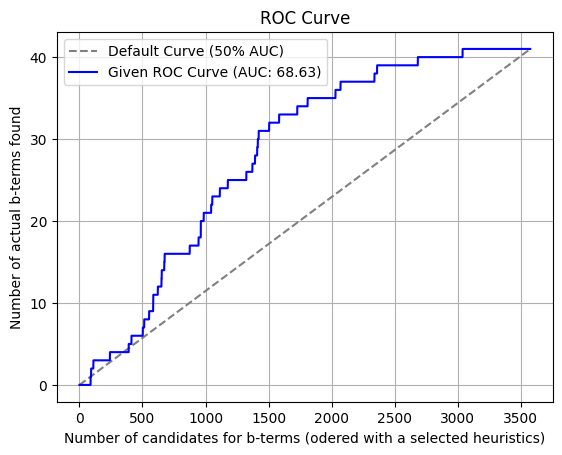

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Example ROC curve points (y-values), replace with the actual list of 120 numbers
roc_points = pt

# X-values for the ROC curve (0 to 120)
x_values = np.arange(0, no_all_bterm_candidates)

# Calculating the AUC for the given ROC curve using the trapezoidal rule
auc = np.trapz(roc_points, x_values) / (no_all_bterm_candidates*no_swansons_bterms) * 100  # Normalizing by the area of the full plot

# Plotting the default curve (50% AUC)
default_x = np.array([0, no_all_bterm_candidates])
default_y = np.array([0, no_swansons_bterms])
plt.plot(default_x, default_y, label='Default Curve (50% AUC)', linestyle='--', color='gray')

# Plotting the given ROC curve
plt.plot(x_values, roc_points, label=f'Given ROC Curve (AUC: {auc:.2f})', color='blue')

# Adding labels and legend
plt.title('ROC Curve')
plt.xlabel('Number of candidates for b-terms (odered with a selected heuristics)')
plt.ylabel('Number of actual b-terms found')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc

In [36]:
# Step 1: Generate Synthetic Data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
# Step 2: Train Multiple Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Neural Network": MLPClassifier(max_iter=1000)
}

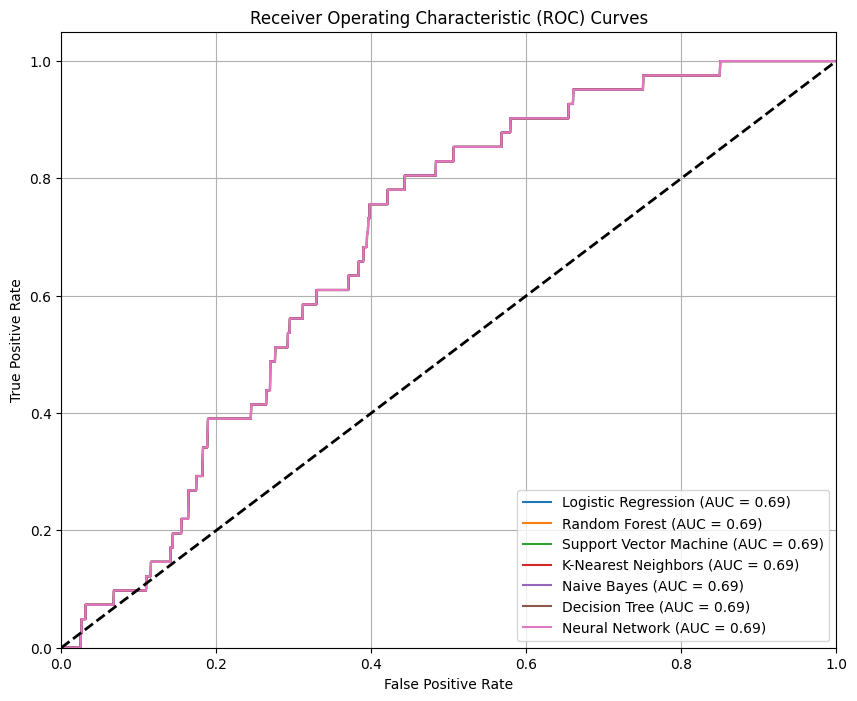

In [39]:
# Step 3: Compute ROC Curves and AUC
plt.figure(figsize=(10, 8))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]  # Probability estimates
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    fpr = part_array
    tpr = suma_array

    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')


# Step 4: Plot ROC Curves
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()